# Проект для «Викишоп»
## Описание проекта
Интернет-магазину «Викишоп» нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

## Инструкция для проекта
1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

## Описание данных
* Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## 1. Загрузите и подготовьте данные.

In [1]:
import pandas as pd
import string
import warnings
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
    display(df.info())
    display(df.head())
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')
    display(df.info())
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**Видим пропусков нет**

Доля токсичных комментов: 0.10167887648758234


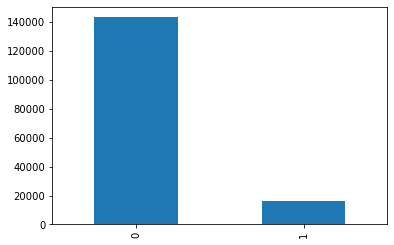

In [3]:
df['toxic'].value_counts().plot(kind='bar')
print('Доля токсичных комментов:',len(df[df['toxic']==1])/len(df))

**Данные несбалансированы - учтем в дальнейшем исследовании**

**Подготовим данные к обучению**

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(nltk_stopwords.words('english'))
punctuation = string.punctuation 
wordnet_lemmatizer = WordNetLemmatizer()
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Прежде чем извлечь признаки из текста, упростим его.**

In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def tokenize_lemmatize(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    tokens = list(filter(lambda t: t not in punctuation, tokens)) 
    tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
    filtered_tokens = []
    for i in tokens:
        if re.search('[a-zA-Z]', i):
            filtered_tokens.append(i)
    filtered_tokens = list(
        map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens))
    filtered_tokens = list(filter(lambda t: t not in punctuation, filtered_tokens))
    return ' '.join(filtered_tokens)

In [6]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def tokenize_lemmatize(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    tokens = list(filter(lambda t: t not in punctuation, tokens)) 
    tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
    tokens = list(
        map(lambda token: wordnet_lemmatizer.lemmatize(token.lower(), get_wordnet_pos(token.lower())), tokens))
    return ' '.join(tokens)

In [7]:
df['text_clean'] = df['text'].map(tokenize_lemmatize)

In [8]:
df

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour 'm seemingly stu...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man 'm really try edit war 's guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,`` ca n't make real suggestion improvement won...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page 's
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,`` second time ask view completely contradicts...
159567,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing put talk page 128.61.19.93
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there actual article prostitution ...
159569,And it looks like it was actually you who put ...,0,look like actually put speedy first version de...


**Разделим датасет на выборки**

In [9]:
train_test, valid = train_test_split(df,test_size=0.2,shuffle = False)
train, test = train_test_split(train_test, test_size=0.2, shuffle=False)

**Вычислим TF-IDF**

In [10]:
train_corpus = train['text_clean'].values
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tfidf_train = count_tf_idf.fit_transform(train_corpus)

target_train = train['toxic']

In [11]:
valid_corpus = valid['text_clean'].values
tfidf_valid = count_tf_idf.transform(valid_corpus)

target_valid = valid['toxic']

### Вывод: Таким образом, мы изучили данные и увидели, что классы несбалансированы. Также подготовили тексты к обучению: лемматизировали и поделили датасет на выборки

## 2. Обучите разные модели.

Обучим следующие модели:
* LogisticRegression
* RidgeClassifier
* CatBoostClassifier
* LGBMClassifier

Посчитаем для них f1_score и выберем лучшую модель

**LogisticRegression**

In [12]:
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(tfidf_train, target_train)

predictions = lr_model.predict(tfidf_valid)
print('f1_score:', f1_score(target_valid, predictions))

f1_score: 0.7217160212604403


**RidgeClassifier**

In [13]:
ridge_model = RidgeClassifier(alpha = 0.2, normalize = True, random_state=12345)
ridge_model.fit(tfidf_train, target_train)
predictions = ridge_model.predict(tfidf_valid)
print('f1_score:', f1_score(target_valid, predictions))

f1_score: 0.639320029563932


**CatBoostClassifier**

In [14]:
cat_model = CatBoostClassifier(learning_rate = 0.3, iterations=50, random_state=12345)
cat_model.fit(tfidf_train, target_train, verbose=10)

cat_predictions = cat_model.predict(tfidf_valid)
cat_f1_score = f1_score(target_valid, cat_predictions)

print("F1_score:", cat_f1_score)

0:	learn: 0.4354591	total: 2.05s	remaining: 1m 40s
10:	learn: 0.2009289	total: 21.3s	remaining: 1m 15s
20:	learn: 0.1789081	total: 39.7s	remaining: 54.8s
30:	learn: 0.1666567	total: 57.5s	remaining: 35.2s
40:	learn: 0.1582095	total: 1m 15s	remaining: 16.5s
49:	learn: 0.1519247	total: 1m 30s	remaining: 0us
F1_score: 0.6809588774118106


**LGBMClassifier**

In [15]:
lgbm_model = LGBMClassifier(learning_rate = 0.3, n_estimators = 20, num_iterations = 40, random_state=12345)
lgbm_model.fit(tfidf_train, target_train)
lgbm_predictions = lgbm_model.predict(tfidf_valid)
lgbm_f1_score = f1_score(target_valid, lgbm_predictions)

print("F1-score:", lgbm_f1_score)

F1-score: 0.7516444444444444


### Вывод: По итогу наилучшей моделью оказалась LGBMClassifier. Пороговое значение достигнуто. Проверим модель на тестовой выборке

## 3. Сделайте выводы.

In [16]:
target_test = test['toxic'] 
test_corpus = test['text_clean'].values.astype('U') 

tfidf_test = count_tf_idf.transform(test_corpus) 

lgbm_model = LGBMClassifier(learning_rate = 0.3, n_estimators = 20, num_iterations = 40, random_state=12345)

lgbm_model.fit(tfidf_train, target_train)
lgbm_predictions_test = lgbm_model.predict(tfidf_test) 
lgbm_f1_score = f1_score(target_test, lgbm_predictions_test) 
lgbm_f1_score

0.7570175438596491

### Вывод: 
В данном проекте были решены следующие задачи:
* Проведен анализ данных;
* Подготовка данных к обучению;
* Подбор наилучшей модели;
* Финальная проверка лучшей модели на тестовой выборке.

Таким образом, на тестовой выборке также удалось достичь значения в 0.75. 